PRUNING FILTERS FOR EFFICIENT CONVNETS (not in date with code)
===

**Reference**: https://arxiv.org/pdf/1608.08710.pdf

**Author**: `Minseong Kim` (tyui592@gmail.com)

### Imports

In [1]:
import os
os.environ['JUPYTER'] = 'True'
# os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-93.7%.pth'
os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-pruned-91.5%.pth  --prune-layers conv1 conv2 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 32 32 256 384 384 384 384 384'

import numpy as np
import matplotlib.pyplot as plt

import torch

from utils import args
from utils.model import get_model
from utils.data import get_dataloader
from procedures.train import train_network
from procedures.evaluate import test_network, test_step
from procedures.prune import prune_step

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Pretrained Model Accuracy

In [2]:
accuracy = test_network()

Files already downloaded and verified
Testing network (11.77), 	Accuracy: 93.65


### Graph the Normalized Absolute Sum of the Filter Weights
This is Figure 2 (a) of the paper.

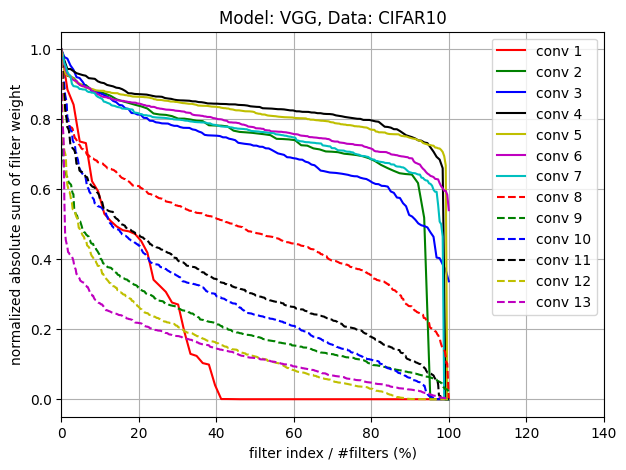

In [9]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']
plt.figure(figsize=(7, 5))
conv_count = 0
model = get_model()
for layer in model.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count % len(colors)] + lines[conv_count // len(colors)]
        
        # Weights are out_ch x in_ch x k1 x k2
        fw = layer.weight.data.cpu().numpy()
        
        # Sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # Normalize with maximum value
        normalized_abs_sum = sorted_abs_sum / sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label="conv %d" % conv_count)
        
plt.title("Model: %s, Data: %s" % (args.model, args.dataset))        
plt.ylabel("normalized absolute sum of filter weight")
plt.xlabel("filter index / #filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
# plt.savefig("plots/figure1.png", dpi=150, bbox_inches='tight')
plt.show()        

### Graph the Accuracy of the Network after Pruning
This is Figure 2 (b) of the paper.

Prune each layer 

In [14]:
prune_step_ratio = 1 / 8
max_channel_ratio = 0.90 

prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']
accuracies = {}

dataloader = get_dataloader(training=False)
accuracy = test_step(model, dataloader)

for conv, channel in zip(prune_layers, prune_channels): 
    print(f"Pruning {conv}")
    
    accuracies[conv] = [accuracy]
    
    # Load new network and check accuracy
    model = get_model()
        
    # Remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel * max_channel_ratio), int(1 / prune_step_ratio), dtype=np.int32)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):        
        model = prune_step(model, [conv], [steps[i]], False)
        
        model = model.to(device)
        accuracy = test_step(model, dataloader)
        accuracies[conv].append(accuracy)

Files already downloaded and verified
Pruning conv1
Pruning conv2
Pruning conv3
Pruning conv4
Pruning conv5
Pruning conv6
Pruning conv7
Pruning conv8
Pruning conv9
Pruning conv10
Pruning conv11
Pruning conv12
Pruning conv13


Plot the accuracy graph

Files already downloaded and verified


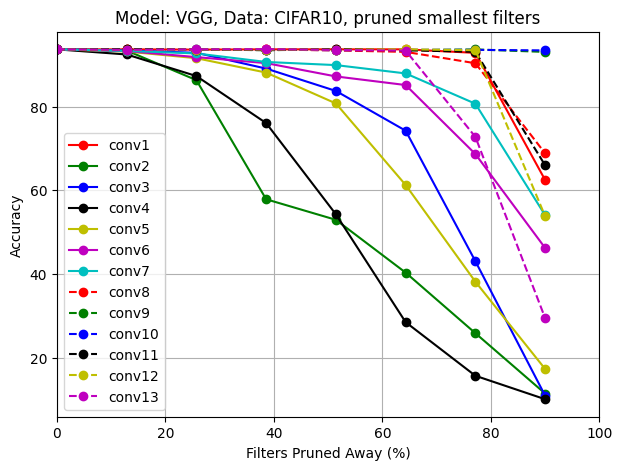

In [36]:
plt.figure(figsize=(7, 5))
for index, (key, value) in enumerate(accuracies.items()):
    line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
    plt.plot(np.linspace(0, 90, len(value)), value, line_style, label=key)

plt.title("Model: %s, Data: %s, pruned smallest filters" % (args.model, args.dataset))        
plt.ylabel("Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
# plt.savefig("plots/figure2.png", dpi=150, bbox_inches='tight')
plt.show()                

### Graph the Accuracy of the Network after Pruning with Retraining
This is Figure 2 (c) of the paper.

Prune each layer with retraining

In [ ]:
args.epochs = 10

accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    print(f"Pruning {conv}")
    
    accuracies[conv] = [accuracy]
    
    model = get_model()
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel * max_channel_ratio), int(1 / prune_step_ratio), dtype=np.int32)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):        
        model = prune_step(model, [conv], [steps[i]], False)
        train_network(model=model, write=False)
        accuracy = test_step(model, dataloader)      
        accuracies[conv].append(accuracy)

Pruning conv1
Files already downloaded and verified
Epoch 1 (41.46048140525818), 	 Accuracy: 94.4425351662404, 	 Loss: 0.15134497936815022
Epoch 2 (38.96871256828308), 	 Accuracy: 95.52149936061382, 	 Loss: 0.15201211217790842


Plot the accuracy graph

In [ ]:
plt.figure(figsize=(7, 5))
for index, (key, value) in enumerate(accuracies.items()):
    line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
    plt.plot(np.linspace(0, 90, len(value)), value, line_style, label=key)

plt.title("Model: %s, Data: %s, pruned smallest filters, retrained %d epochs" % (args.model, args.dataset, args.epochs))        
plt.ylabel("Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("plots/figure2.png", dpi=150, bbox_inches='tight')
plt.show()                